<a href="https://colab.research.google.com/github/SoheilBadri2000/DataScience2/blob/main/23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# base_model

## Create our own dataset (download from google-image)

In [10]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
!pip install simple_image_download

INFO: pip is looking at multiple versions of simple-image-download to determine which version is compatible with other requirements. This could take a while.


In [5]:
from simple_image_download import simple_image_download
response = simple_image_download.simple_image_download()

In [6]:
queries = ["Chris Martin",
           "Michael Jackson",
           "Eminem",
           "Jack Black",
           "Imagine Dragon",
           "Bruno Mars"]

In [8]:
def download_images(queries, limit):
  for query in queries:
    response.download(query, limit)

In [9]:
download_images(queries, 54)

In [11]:
# specify the directory for search results
base_dir = "/content/simple_images"

# Iterate over each folder in base_directory
for folder_name in os.listdir(base_dir):
  folder_path = os.path.join(base_dir, folder_name)

  # check if the path is a directory
  if os.path.isdir(folder_path):
    # create a list of files to remove
    files_to_remove = [f"{folder_name}_{num}.jpg" for num in range(1,5)]
    # iterate over files and remove them
    for file_name in files_to_remove:
      file_path = os.path.join(folder_path, file_name)
      if os.path.exists(file_path):
        os.remove(file_path)

## base_model: The typical transfer-learning workflow

In [16]:
# import packages
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

In [13]:
model = VGG16(weights = "imagenet",
              include_top = False,
              input_shape = (224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
datagenerator = ImageDataGenerator(rescale=1./255)

def feature_extractor(sample_size, batch_size, dir):
  features = np.zeros((sample_size, 7, 7, 512))
  labels = np.zeros(sample_size)
  datagen = datagenerator.flow_from_directory(dir,
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_model="categorical")
  cnt = 0
  for input_pxl, lbl in datagen:
    features_batch = model.predict(input_pxl)
    features[cnt * batch_size : (cnt+1) * batch_size] = features_batch
    labels[cnt * batch_size : (cnt+1) * batch_size] = np.argmax(lbl)
    cnt += 1
    if cnt * batch_size > sample_size:
      break

  return features, labels, datagen.class_indices

In [19]:
# MAKE SURE TO COMPLETE THIS !!!

# Dogs vs Cats

In [9]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content/"

In [6]:
!kaggle competitions download -c dogs-vs-cats

 98% 798M/812M [00:07<00:00, 187MB/s]
100% 812M/812M [00:07<00:00, 109MB/s]


In [13]:
# Unzip the dataset and set the path to the training and test set
with zipfile.ZipFile("dogs-vs-cats.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/dogs-vs-cats")

with zipfile.ZipFile("dogs-vs-cats/train.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/dogs-vs-cats")

with zipfile.ZipFile("dogs-vs-cats/test1.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/dogs-vs-cats")

base_dir = "/content/dogs-vs-cats"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test1")

In [14]:
n_train = len(os.listdir(train_dir))
n_test = len(os.listdir(test_dir))

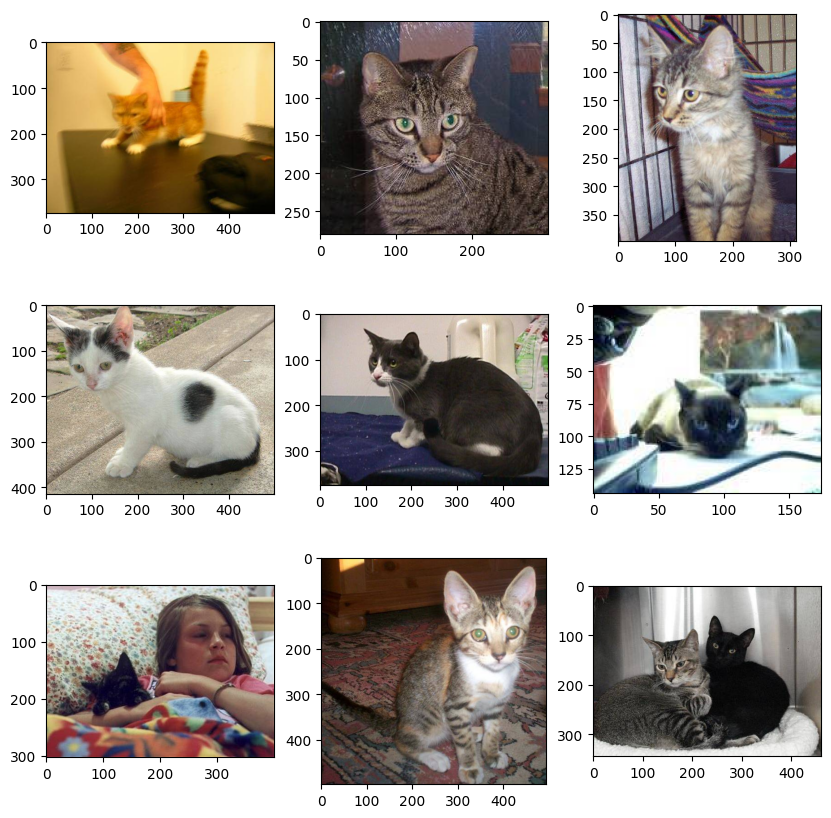

In [15]:
# plot the first few images
plt.figure(figsize=(10, 10))
for i in range(9):
  # define subplot
  plt.subplot(331 + i)
  # define filename
  filename = train_dir + "/cat." + str(i) + ".jpg"
  # load image pixels
  image = plt.imread(filename)
  # plot raw pixel data
  plt.imshow(image)

plt.show()

In [24]:
# # load the images from their location
# from keras.utils import image_dataset_from_directory
# training_set = image_dataset_from_directory(train_dir,
#                                             shuffle = True,
#                                             batch_size = 4,
#                                             image_size = (150, 150))
# training_set = image_dataset_from_directory(test_dir,
#                                             shuffle = True,
#                                             batch_size = 4,
#                                             image_size = (150, 150))

## Continue with Tensorflow cat-dog dataset

In [1]:
#gpu
from tensorflow import config
physical_devices = config.experimental.list_physical_devices("GPU")
print("Num GPUs Available:", len(physical_devices))
config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available: 1


In [7]:
import tensorflow_datasets as tfds

# Disables tqdm progress bar
# tfds.disable_progress_bar()

# load dataset
train_ds, validation_ds, test_ds = tfds.load("cats_vs_dogs",
                                             # Reserve 10% for validation and 10% for test
                                             split = ["train[:20%]", "train[20%:25%]", "train[25%:30%]"],
                                             as_supervised=True)

print(f"Number of training samples:\t{tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation samples:\t{tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test samples:\t\t{tf.data.experimental.cardinality(train_ds)}")

Number of training samples:	4652
Number of validation samples:	1164
Number of test samples:		4652


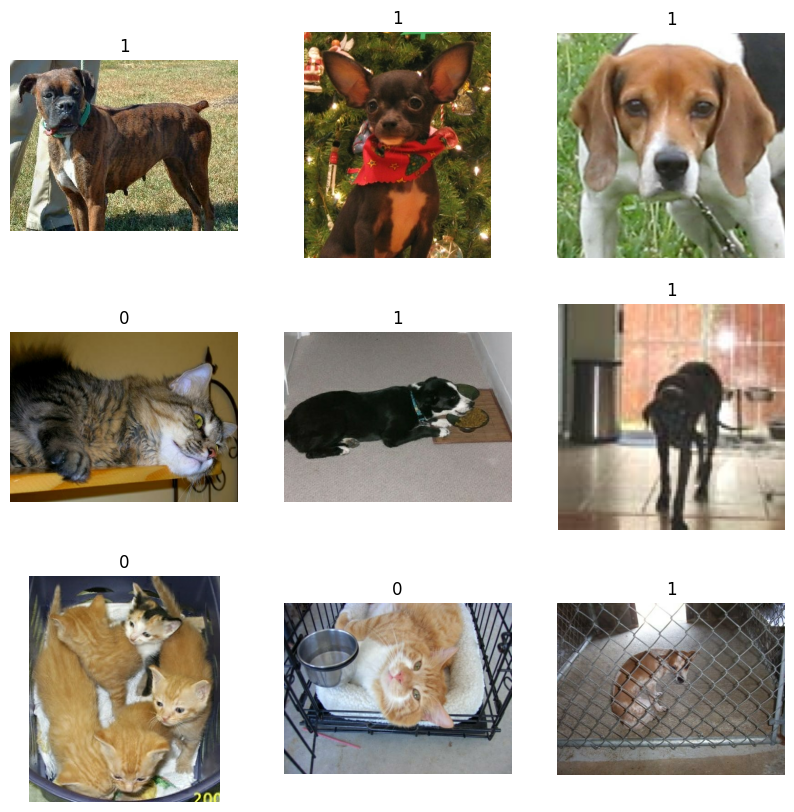

In [10]:
# display some images from dataset
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

## Data pre-processing and augmentation

In [11]:
# data preparation
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [12]:
# system setup
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().cache().batch(batch_size).prefetch(buffer_size=10)

In [13]:
data_augmentation = keras.Sequential(
    [keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     keras.layers.experimental.preprocessing.RandomRotation(0.1),
     keras.layers.experimental.preprocessing.RandomZoom(0.05, 0.05, fill_mode="nearest")]
)

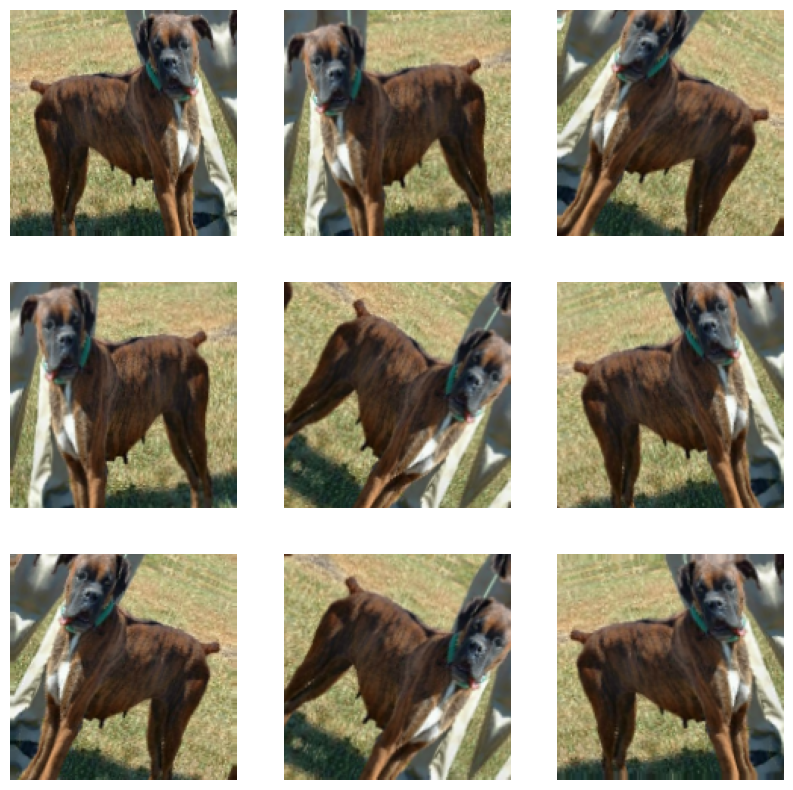

In [15]:
for images, labels, in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image,0), training=True)
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.axis("off")

In [16]:
# create a base model from the pre-trained VGG model
base_model = keras.applications.VGG16(weights = "imagenet",
                                      # load weights pre-trained on ImageNet
                                      input_shape = (150, 150, 3),
                                      include_top = False)
                                      # do not include the ImageNet classifier at the top

base_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [18]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs) # Apply random data augmentation

# Pre-trained VGG weights requires that input be normalized
# This  model expects data in the range of (-1, 1) and not (0, 1)
x = tf.keras.applications.vgg16.preprocess_input(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine_tuning, so we make sure that the base model is running in inference mode here
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (1, 150, 150, 3)          0         
                                                                 
 tf.__operators__.getitem (  (None, 150, 150, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 150, 150, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0     

In [20]:
# Train the model
model.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = [keras.metrics.BinaryAccuracy()])

epochs = 5
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5
146/146 [==============================] - 25s 107ms/step - loss: 0.9423 - binary_accuracy: 0.8315 - val_loss: 0.3205 - val_binary_accuracy: 0.9399
Epoch 2/5
146/146 [==============================] - 13s 88ms/step - loss: 0.4312 - binary_accuracy: 0.9082 - val_loss: 0.2321 - val_binary_accuracy: 0.9570
Epoch 3/5
146/146 [==============================] - 12s 85ms/step - loss: 0.3492 - binary_accuracy: 0.9205 - val_loss: 0.2119 - val_binary_accuracy: 0.9648
Epoch 4/5
146/146 [==============================] - 13s 87ms/step - loss: 0.2775 - binary_accuracy: 0.9310 - val_loss: 0.2007 - val_binary_accuracy: 0.9639
Epoch 5/5
146/146 [==============================] - 13s 86ms/step - loss: 0.2551 - binary_accuracy: 0.9325 - val_loss: 0.2021 - val_binary_accuracy: 0.9656


In [21]:
# items in history
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

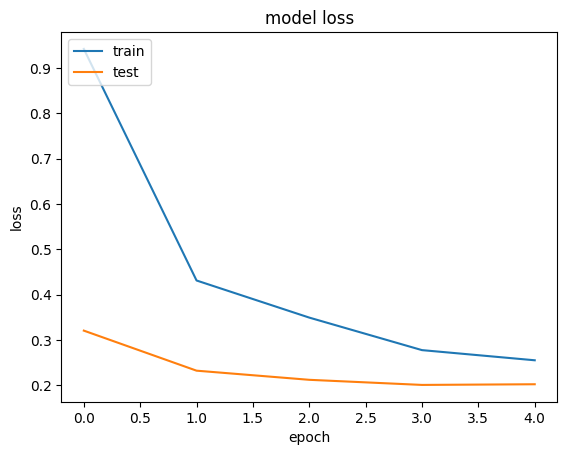

In [22]:
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

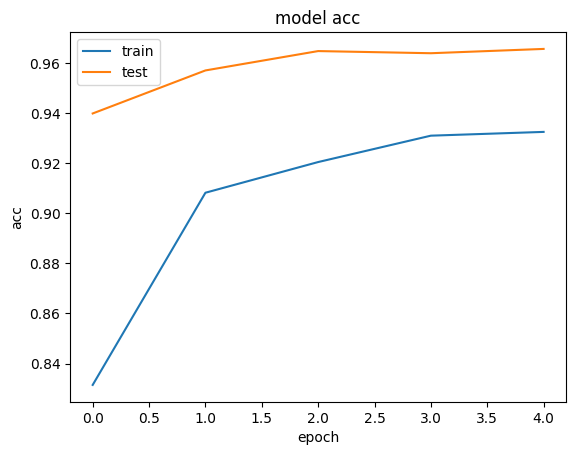

In [23]:
# summarize history for loss
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("model acc")
plt.ylabel("acc")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Fine-tuning the model

In [24]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (1, 150, 150, 3)          0         
                                                                 
 tf.__operators__.getitem (  (None, 150, 150, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 150, 150, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0     

In [26]:
model.compile(optimizer = keras.optimizers.Adam(1e-5),
              loss = keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = [keras.metrics.BinaryAccuracy()])

epoch = 5
history2 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5
146/146 [==============================] - 49s 248ms/step - loss: 0.1790 - binary_accuracy: 0.9362 - val_loss: 0.0953 - val_binary_accuracy: 0.9751
Epoch 2/5
146/146 [==============================] - 34s 231ms/step - loss: 0.0901 - binary_accuracy: 0.9667 - val_loss: 0.1060 - val_binary_accuracy: 0.9682
Epoch 3/5
146/146 [==============================] - 34s 234ms/step - loss: 0.0749 - binary_accuracy: 0.9723 - val_loss: 0.1049 - val_binary_accuracy: 0.9734
Epoch 4/5
146/146 [==============================] - 35s 238ms/step - loss: 0.0577 - binary_accuracy: 0.9768 - val_loss: 0.0924 - val_binary_accuracy: 0.9716
Epoch 5/5
146/146 [==============================] - 35s 239ms/step - loss: 0.0430 - binary_accuracy: 0.9815 - val_loss: 0.1043 - val_binary_accuracy: 0.9716


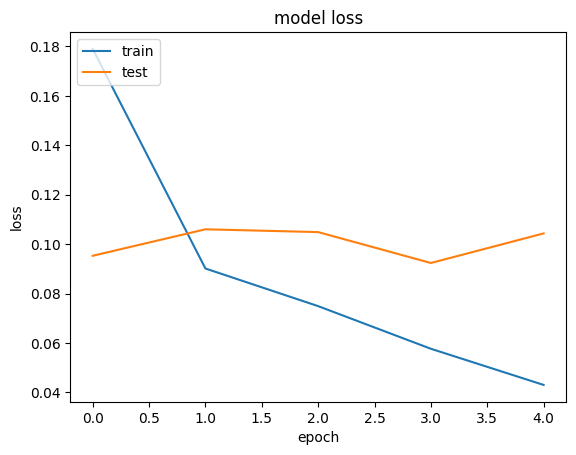

In [27]:
# summarize history for loss
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [28]:
# in case need to have predicted labels (now, we don't need it)
predictions = model.predict(test_ds)

37/37 [==============================] - 6s 141ms/step


In [29]:
# Evaluate the best model with testing data
print(model.evaluate(x=test_ds))

37/37 [==============================] - 3s 71ms/step - loss: 0.0604 - binary_accuracy: 0.9785
[0.06042764335870743, 0.9785038828849792]


In [30]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [31]:
# create a base model from the pre-trained VGG model
base_model = keras.applications.VGG16(weights = "imagenet",
                                      input_shape = (150, 150, 3),
                                      include_top = False)

In [32]:
# Freeze the base_model
set_trainable = False
for lyr in base_model.layers:
  if lyr.name =="block5_conv1":
    set_trainable = True
  if set_trainable:
    lyr.trainable = True
  else:
    lyr.trainable = False

In [33]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [34]:
# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs) # Apply random data augmentation

# Pre-trained VGG weights requires that input be normalized
# This  model expects data in the range of (-1, 1) and not (0, 1)
x = tf.keras.applications.vgg16.preprocess_input(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine_tuning, so we make sure that the base model is running in inference mode here
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (1, 150, 150, 3)          0         
                                                                 
 tf.__operators__.getitem_1  (None, 150, 150, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0   

In [35]:
model.compile(optimizer = keras.optimizers.Adam(1e-5), # Low learning rate
              loss = keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = [keras.metrics.BinaryAccuracy()])

epochs = 5
history3 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5
146/146 [==============================] - 18s 100ms/step - loss: 0.6862 - binary_accuracy: 0.8381 - val_loss: 0.2055 - val_binary_accuracy: 0.9364
Epoch 2/5
146/146 [==============================] - 14s 98ms/step - loss: 0.2103 - binary_accuracy: 0.9142 - val_loss: 0.1624 - val_binary_accuracy: 0.9467
Epoch 3/5
146/146 [==============================] - 15s 102ms/step - loss: 0.1630 - binary_accuracy: 0.9323 - val_loss: 0.1386 - val_binary_accuracy: 0.9562
Epoch 4/5
146/146 [==============================] - 16s 110ms/step - loss: 0.1215 - binary_accuracy: 0.9495 - val_loss: 0.1431 - val_binary_accuracy: 0.9588
Epoch 5/5
146/146 [==============================] - 16s 109ms/step - loss: 0.1089 - binary_accuracy: 0.9549 - val_loss: 0.1370 - val_binary_accuracy: 0.9622


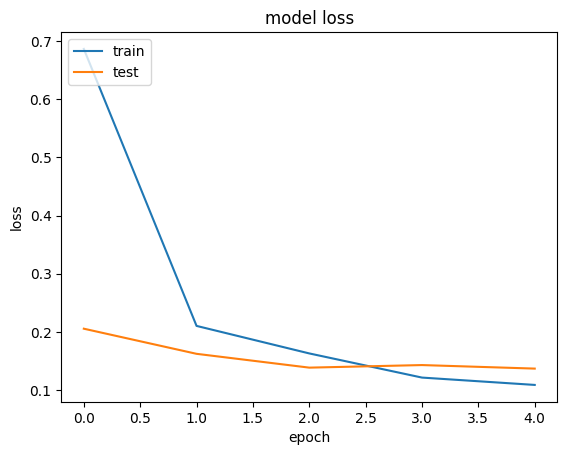

In [36]:
# summarize history for loss
plt.plot(history3.history["loss"])
plt.plot(history3.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()